In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11.tools import df_from_dict_of_tuples
from e11.fit import Gaussian

The `e11.fit` module contains classes that simplify fitting common functions to data.  The classes use statistical features of the data to make *intelligent* initial guesses at the fit parameters (so you don't have to).  This is particularly useful for bulk fitting operations.

## Generate data

In [2]:
Gaussian.get_variables()

('x', 'x0', 'amp', 'sigma', 'offset')

In [3]:
# generate 1d data
nx = 500
xvals = np.arange(nx)
arr = []
std = 1.2
labels = [-1.4, -0.5, 0.4]
data_pars = {}
for lbl, x0, amp, sigma in zip(labels,
                               [100, 200, 300],
                               [18, 12, 6],
                               [40, 50, 60]):
    p0 = [x0, amp, sigma, 2]
    data_pars[lbl] = dict(zip(Gaussian.get_variables()[1:], p0))
    yvals = Gaussian.func(xvals, *p0) + std * np.random.randn(nx)
    arr.append(yvals)
arr = np.array(arr)
data_pars = pd.DataFrame.from_dict(data_pars, orient="index")

In [4]:
data_pars

,x0,amp,sigma,offset
-1.4,100,18,40,2
-0.5,200,12,50,2
0.4,300,6,60,2


## Fit data

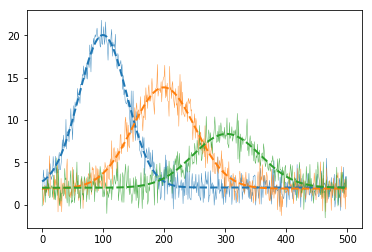

In [5]:
fig, ax = plt.subplots()

fit_pars = {}
reduced_chi_sq = {}
for lbl, yvals in zip(labels, arr):
    # data
    p = ax.plot(xvals, yvals, lw=0.5, alpha=0.8, zorder=5)
    color = p[0].get_color()
    # fit
    g = Gaussian(xvals, yvals)
    popt, perr = g.fit()
    ax.plot(g.xdata, g.best_fit, color=color, ls="--", lw=2, zorder=10)
    # reduced chi_sq
    reduced_chi_sq[lbl] = np.sum(g.residuals**2 / (std**2)) / (nx - len(g.get_variables()))
    # record
    fit_pars[lbl] = g.asdict()

fit_pars = df_from_dict_of_tuples(fit_pars)
plt.show()

In [6]:
pd.Series(reduced_chi_sq)

-1.4    0.929223
-0.5    1.066083
 0.4    0.955107
dtype: float64

In [7]:
fit_pars

x0                  amp                sigma            \
           value     error      value     error      value     error   
-1.4   99.731183  0.427246  18.021563  0.177135  39.248025  0.470395   
-0.5  199.378255  0.786495  11.960495  0.169404  51.188874  0.929424   
 0.4  302.387199  1.452472   6.368039  0.156110  55.238394  1.759582   

        offset            
         value     error  
-1.4  2.034891  0.066422  
-0.5  1.907521  0.081952  
 0.4  2.005067  0.081364

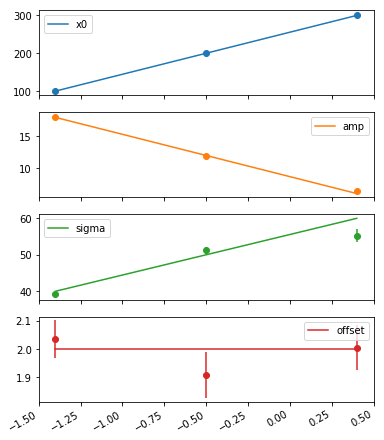

In [8]:
axes = data_pars.plot(subplots=True, figsize=(6, 8))

for i, var in enumerate(g.get_variables()[1:]):
    yvals = fit_pars[(var, "value")]
    yerr = fit_pars[(var, "error")]
    axes[i].errorbar(yvals.index, yvals.values, yerr=yerr.values, c="C%d"%i, ls="", marker="o")
axes[-1].set_xlim(-1.5, 0.5)
plt.show()

# Example 1D fit functions

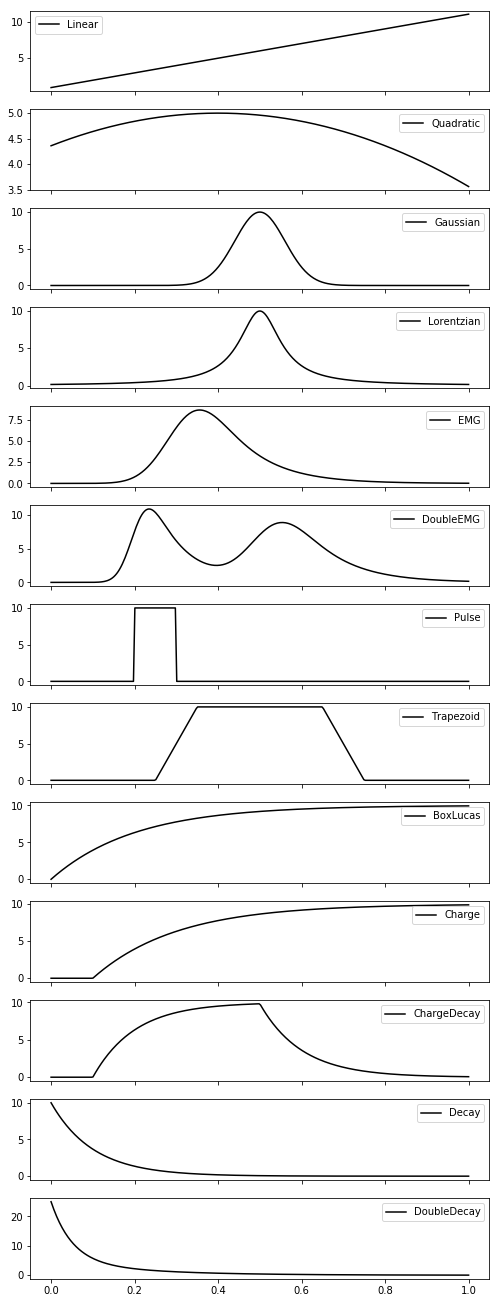

In [9]:
import e11.fit as fit
fit_funcs = [fit.Linear, fit.Quadratic, fit.Gaussian, fit.Lorentzian,
             fit.EMG, fit.DoubleEMG, fit.Pulse, fit.Trapezoid,
             fit.BoxLucas, fit.Charge, fit.ChargeDecay, fit.Decay, fit.DoubleDecay]

fig, ax = plt.subplots(len(fit_funcs), 1, figsize=(7, 1.4*len(fit_funcs)), sharex=True)

xvals = np.linspace(0, 1, 300)

params = {"Linear":[10, 1],
          "Quadratic":[0.4, -4, 5],
          "Gaussian":[0.5, 10, .06, 0],
          "Lorentzian":[0.5, 10, .06, 0],
          "EMG":[0.3, 10, .06, 0.1, 0],
          "DoubleEMG":[0.2, 10, .03, 0.08, 0.5, 10, .06, 0.1, 0],
          "Pulse":[0.2, 0.1, 10, 0],
          "Trapezoid":[0.3, 0.4, 0.1, 10, 0], 
          "BoxLucas": [0.2, 10, 0],
          "Charge": [0.1, 0.2, 10, 0],
          "ChargeDecay": [0.1, 0.4, 0.1, 10, 0],
          "Decay": [10, 0.1],
          "DoubleDecay": [20, 0.05, 5, 0.2]}

for i, f in enumerate(fit_funcs):
    name = f.__name__
    ax[i].plot(xvals, f.func(xvals, *params[name]), c='k', label=name)
    ax[i].legend()

plt.tight_layout()
plt.show()

{'x0': (1.1006366317538927, 0.0023730955274581522), 'amp': (-4.0162895756121255, 0.03410019896553747), 'offset': (4.996381345171012, 0.015405724414504605)}


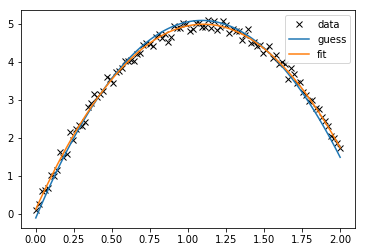

In [10]:
# quadratic fit
xvals = np.linspace(0, 2, 100)
pars = [1.1, -4, 5]
yvals = pars[1] * (xvals - pars[0])**2.0 + pars[2] + 0.1*np.random.randn(len(xvals))

f = fit.Quadratic(xvals, yvals)
popt, perr = f.fit()
print(f.asdict())

# plot
fig, ax = plt.subplots()
ax.plot(xvals, yvals, 'x', label="data", c='k')
ax.plot(f.xdata, f.func(f.xdata, *f.approx()), label="guess")
ax.plot(f.xdata, f.best_fit, label="fit")
ax.legend()
plt.show()